# Introduction

## Change in Density

In [ ]:
%reload_ext tensorboard
%reload_ext autoreload

In [ ]:
import os
import torch
import pyvista as pv
import torch.distributions as tdist
from regilib.core.invertible_modules.bijective.deterministic import AffineTransform
from regilib.core.dynamics.dynamical_state import DynamicalState
from regilib.core.numerics.derivatives import batch_jacobian
from regilib.core.invertible_modules.invertible_module import InvertibleModule
from regilib.core.invertible_modules.charts import SphericalCoordProj

In [ ]:
root='../results/introduction/'

In [ ]:
def cat_zeros(x): return torch.cat([x.clone(), torch.zeros(x.shape[0], 1)], 1).detach().numpy()

## uniform distribution

In [ ]:
base_dist = tdist.Normal(0, 0.2)

_uniform_grid = torch.stack(torch.meshgrid(
    torch.linspace(-1, +1, 10),
    torch.linspace(-1, +1, 10)
), -1).view(-1, 2)

base_grid = DynamicalState(
    state = _uniform_grid.requires_grad_(True), 
    log_prob = base_dist.log_prob(_uniform_grid).sum(-1)
)
    
base_samples = DynamicalState(
    state := base_dist.sample([1000, 2]).requires_grad_(True),
    log_prob = base_dist.log_prob(state).sum(-1)
)

/home/bawaw/.conda/envs/pdm_tutorial/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


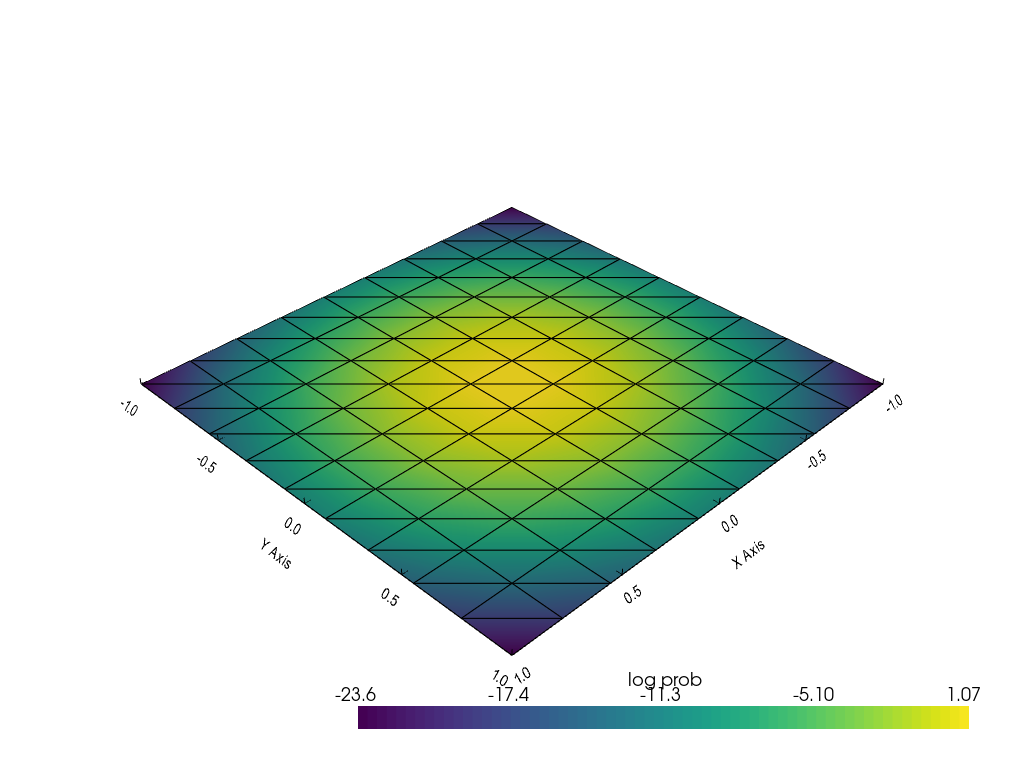

In [ ]:
pv.set_plot_theme("document")

pv.set_jupyter_backend('None')

plotter = pv.Plotter()
plotter.add_mesh(
    pv.PolyData(cat_zeros(base_grid.state)).delaunay_2d(),
    show_edges=True,
    render_points_as_spheres=True, scalars = base_grid.log_prob.detach(),
    scalar_bar_args={'title': 'log prob'}
)

# plotter.add_mesh(
#     pv.PolyData(cat_zeros(base_samples.state)),
#     render_points_as_spheres=True, point_size=8)

plotter.show_bounds()
plotter.screenshot(os.path.join(root, 'plane.png'))
plotter.show()

## Elu transform

In [ ]:
class EluTransform(InvertibleModule):
    def forward(self, ds, **kwargs):
        state_in = ds['state']
        state_out = torch.nn.functional.elu(state_in)
        ds['state'] = state_out

        # p(x) -= |log det Jf(z)|
        if hasattr(ds, 'log_prob'):
            ds['log_prob'] -= batch_jacobian(state_out, state_in).slogdet()[1]

        return ds
    
t1 = EluTransform()

In [ ]:
elu_grid, elu_samples = t1(base_grid.clone()), t1(base_samples.clone())

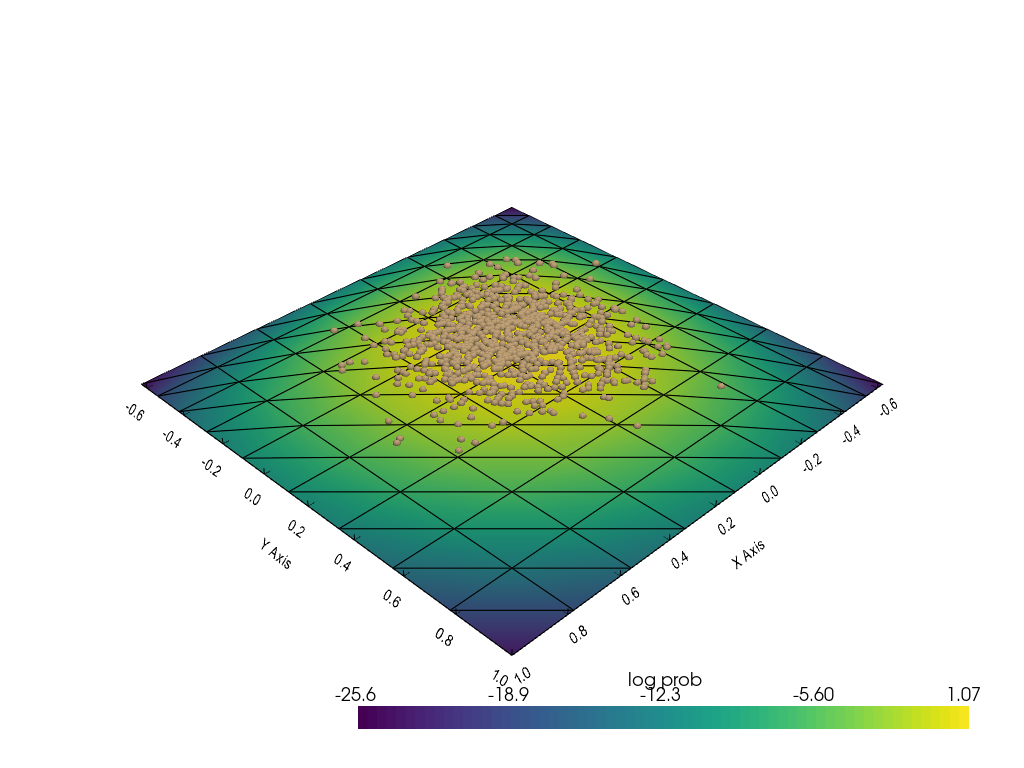

In [ ]:
pv.set_plot_theme("document")

pv.set_jupyter_backend('None')

plotter = pv.Plotter()
plotter.add_mesh(
    pv.PolyData(cat_zeros(elu_grid.state)).delaunay_2d(),
    show_edges=True,
    render_points_as_spheres=True, scalars = elu_grid.log_prob.detach(),
    scalar_bar_args={'title': 'log prob'}
)

plotter.add_mesh(
    pv.PolyData(cat_zeros(elu_samples.state)),
    render_points_as_spheres=True, point_size=8)

plotter.show_bounds()
plotter.screenshot(os.path.join(root, 'elu.png'))
plotter.show()

## Stereographic projection

In [10]:
class StereoCoordProj(InvertibleModule):
    def forward(self, ds, **kwargs):
        state_in = ds['state']
        psi, gamma = state_in.T
        x, y, z = 2*psi/(1+psi**2+gamma**2), 2*gamma/(1+psi**2+gamma**2), (-1+psi**2+gamma**2)/(1+psi**2+gamma**2)
        state_out = torch.stack([x, y, z], -1)

        # p(x) -= 1/2 log det [J_f^T(u)J_f(u)]
        if hasattr(ds, 'log_prob'):
            Jf = batch_jacobian(state_out, state_in)
            ds['log_prob'] -= 0.5 * torch.bmm(
                torch.transpose(Jf, -2, -1), Jf).slogdet()[1]
        ds['state'] = state_out

        return ds

t2 = StereoCoordProj()

In [11]:
stereo_grid, stereo_samples = t2(base_grid.clone()), t2(base_samples.clone())

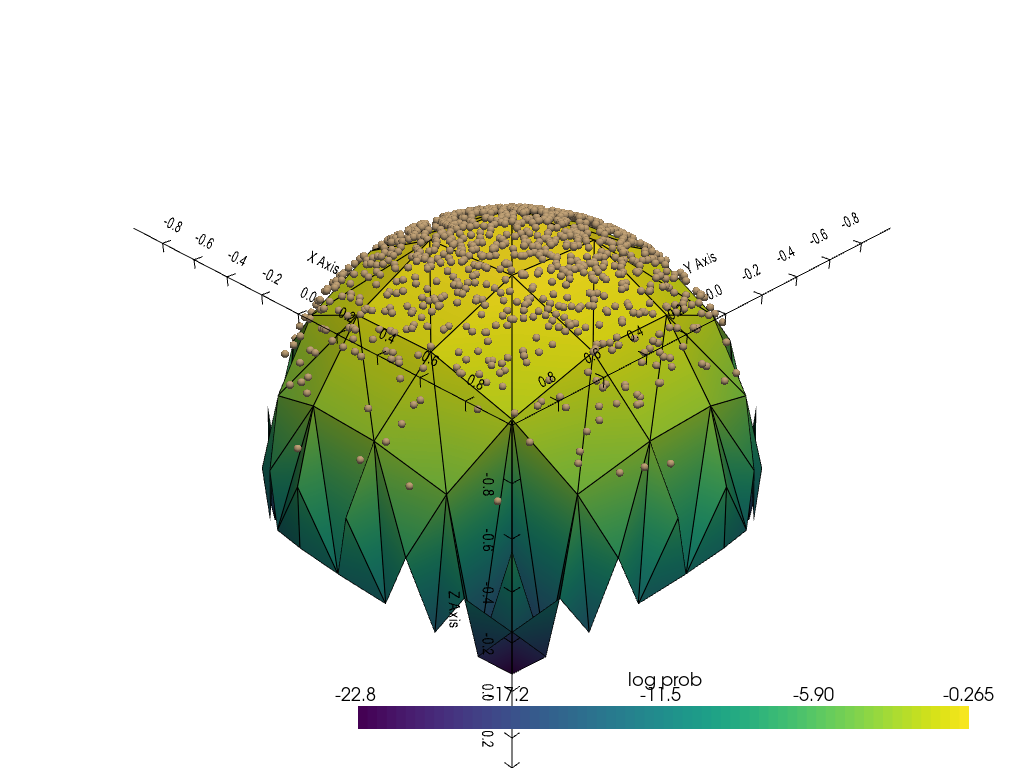

In [12]:
pv.set_plot_theme("document")

pv.set_jupyter_backend('None')

plotter = pv.Plotter()
plotter.add_mesh(
    pv.PolyData(stereo_grid.state.detach().numpy()).delaunay_2d(),
    show_edges=True,
    render_points_as_spheres=True, 
    scalars = stereo_grid.log_prob.detach(),
    scalar_bar_args={'title': 'log prob'}
)

plotter.add_mesh(
    pv.PolyData(stereo_samples.state.detach().numpy()),
    render_points_as_spheres=True, point_size=8)

plotter.camera_position = [
    (3.470023427913145, 3.470023427913145, -3.136828710148291),
    (0.0, 0.0, -0.33319471776485443),
    (0.0, 0.0, -1.0)
]
plotter.show_bounds()
plotter.screenshot(os.path.join(root, 'sphere.png'))
plotter.show()